# 프로젝트: 퍼스널 컬러 진단 - VGG16

## 데이터
1. 유명인 웜톤 100장, 쿨톤 100장  
2. 일반인 웜톤 490장, 쿨톤 186장  

## 목표: VGG16 아키텍처에 퍼스널컬러 적용하기  
참고 링크:https://eremo2002.tistory.com/55   

## 모델 환경
1. VGG16의 마지막 Dense layer 부분은 추가 수정함  
2. 이진 분류이지만 웜/쿨 확률 출력을 위하여 softmax(마지막 layer 2개) 사용  
3. 2번에 따라서 컴파일은 optimazir = adam, loss = sparse_categorical_corssentropy, metrics = accuracy  

## (1) 라이브러리 및 데이터 불러오기

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import vgg16

import numpy as np
import cv2
import os
import glob
from PIL import Image

In [2]:
# 파일 불러오는 함수
def load_images_from_directory(directory_path):
    image_paths = glob.glob(directory_path + '/*.jpg')  # 디렉토리 내의 모든 jpg 파일 경로 찾기
    image_paths.extend(glob.glob(directory_path + '/*.jpeg'))  # 디렉토리 내의 모든 jpeg 파일 경로 추가
    image_paths.extend(glob.glob(directory_path + '/*.JPG'))  # 디렉토리 내의 모든 JPG 파일 경로 찾기

    images = []
    i = 0
    for image_path in image_paths:
        if i == 180: # 웜쿨 비율 맞추기 + 계속 커널 끊기는 현상 막기 위해 최대 각각 180장만 가져옴
            break
        image = Image.open(image_path)
        image_np = np.array(image)
        images.append(image_np)
        i += 1

    return images

In [3]:
# 모든 이미지 불러오기
directory_path1 = "/aiffel//aiffel/project/first-repository/data/four_seasons/train_warm_1"  # 디렉토리 경로
directory_path2 = "/aiffel/aiffel/project/first-repository/data/four_seasons/train_cool_1/cool_1"  # 디렉토리 경로
images1 = load_images_from_directory(directory_path1)
images2 = load_images_from_directory(directory_path2)

length = len(images1)
print(length)
print(len(images2))

# 이미지 리스트 합치기
images = np.concatenate((images1, images2), axis=0)
print(len(images))

180
180
360


<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


## (2) 데이터 전처리

In [4]:
def preprocess_image(image):
    # 이미지 크기 조절
    image = tf.image.resize(image, (224, 224))
    # 이미지를 [0, 1] 범위로 정규화
    image = image / 255.0
    return image

images = np.array([preprocess_image(image) for image in images])
print(images.shape)

(360, 224, 224, 3)


In [5]:
from tensorflow.keras.utils import to_categorical

# labels에 대한 코드
num = len(images)
labels = np.zeros(num)

# 뒤쪽의 50개의 요소를 1로 변경
labels[length:] = 1

# labels = to_categorical(labels, num_classes=2)

# 0이 웜톤 1이 쿨톤
print(len(images))
print(labels.shape)
print(labels)

360
(360,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 

## (3) train, val 분리하기

In [94]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(images,
                                                  labels,
                                                  test_size=0.3,
                                                  random_state=18)

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_val: ", x_val.shape)
print("y_val: ", y_val.shape)

x_train:  (252, 224, 224, 3)
y_train:  (252,)
x_val:  (108, 224, 224, 3)
y_val:  (108,)


In [95]:
from keras.preprocessing.image import ImageDataGenerator

# 이미지 증강을 위한 ImageDataGenerator 생성
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# 이미지 증강 적용하여 증강된 이미지를 배치로 생성
augmented_images = datagen.flow(images, batch_size=32)

In [96]:
# 데이터를 텐서로 변환
# x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
# x_val = tf.convert_to_tensor(x_val, dtype=tf.float32)
# y_train = tf.convert_to_tensor(y_train, dtype=tf.int32)
# y_val = tf.convert_to_tensor(y_val, dtype=tf.int32)

## (4) 모델 정의 및 컴파일

In [97]:
from keras.models import Model
from keras import Input
from keras import optimizers, initializers, regularizers, metrics

dim1 = 32
dim2 = 64

input_tensor = Input(shape=(224, 224, 3), dtype='float32', name='input')
 
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(input_tensor)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.MaxPooling2D((2,2))(x)
 
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.MaxPooling2D((2,2))(x)
 
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.MaxPooling2D((2,2))(x)
 
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.MaxPooling2D((2,2))(x)
 
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.01))(x)
x = layers.MaxPooling2D((2,2))(x)
 
x = layers.Flatten()(x)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(32, activation='relu')(x)
output_tensor = layers.Dense(2, activation='softmax')(x)
 
model = Model(input_tensor, output_tensor)
model.summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d_104 (Conv2D)          (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_105 (Conv2D)          (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_106 (Conv2D)          (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_107 (Conv2D)          (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 56, 56, 128)       0   

In [98]:
learning_rate = 0.000001
adam = tf.keras.optimizers.Adam(lr=learning_rate)

# 모델 컴파일
model.compile(optimizer= adam,
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


## (5) 모델 학습하기

In [99]:
history = model.fit(x_train, y_train,
                    batch_size=16,
                    epochs=30,
                    validation_data=(x_val, y_val))

Epoch 1/30
16/16 [==============================] - 5s 256ms/step - loss: 85.1418 - accuracy: 0.5833 - val_loss: 85.0739 - val_accuracy: 0.6759
Epoch 2/30
16/16 [==============================] - 4s 231ms/step - loss: 85.0408 - accuracy: 0.7103 - val_loss: 84.9863 - val_accuracy: 0.8241
Epoch 3/30
16/16 [==============================] - 4s 231ms/step - loss: 84.9491 - accuracy: 0.7976 - val_loss: 84.9106 - val_accuracy: 0.8241
Epoch 4/30
16/16 [==============================] - 4s 233ms/step - loss: 84.8689 - accuracy: 0.8254 - val_loss: 84.8365 - val_accuracy: 0.8056
Epoch 5/30
16/16 [==============================] - 4s 235ms/step - loss: 84.7869 - accuracy: 0.8413 - val_loss: 84.7639 - val_accuracy: 0.8241
Epoch 6/30
16/16 [==============================] - 4s 235ms/step - loss: 84.7101 - accuracy: 0.8532 - val_loss: 84.6906 - val_accuracy: 0.8241
Epoch 7/30
16/16 [==============================] - 4s 235ms/step - loss: 84.6504 - accuracy: 0.8095 - val_loss: 84.6269 - val_accuracy:

## (6) 예측하기

In [100]:
pred = model.predict(x_val)
pred_class = np.argmax(pred, axis=1)
# y_val = np.argmax(y_val, axis=1)

In [101]:
print(pred_class)
print(y_val)
print(pred)

[0 0 1 1 1 1 1 0 1 1 0 0 1 0 1 1 1 0 0 0 1 1 1 0 1 1 1 0 0 1 1 1 1 0 1 1 0
 0 0 1 0 0 0 1 1 0 0 1 0 1 0 1 0 0 1 0 1 1 0 1 0 1 0 0 1 0 1 1 1 0 1 0 1 0
 1 1 1 0 1 0 1 1 0 0 0 0 1 0 1 1 1 0 0 0 1 1 1 0 1 0 1 1 1 1 1 0 0 1]
[1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0.
 1. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1.
 0. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 1. 0. 1. 0.
 1. 0. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0.
 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1.]
[[0.57171196 0.42828807]
 [0.7138979  0.28610212]
 [0.13241805 0.8675819 ]
 [0.10607146 0.8939286 ]
 [0.37784716 0.6221528 ]
 [0.12198911 0.87801087]
 [0.21669327 0.7833067 ]
 [0.91477036 0.08522967]
 [0.16907574 0.83092433]
 [0.18096013 0.8190399 ]
 [0.9605629  0.03943713]
 [0.7962335  0.20376647]
 [0.14363924 0.8563608 ]
 [0.83577836 0.16422161]
 [0.0787793  0.9212207 ]
 [0.21048567 0.78951436]
 [0.472923   0.527077  ]
 [0.80126625 0.19873376]


In [102]:
acc = np.mean(pred_class == y_val)
print('accuracy: %f' % (acc,))

accuracy: 0.879630


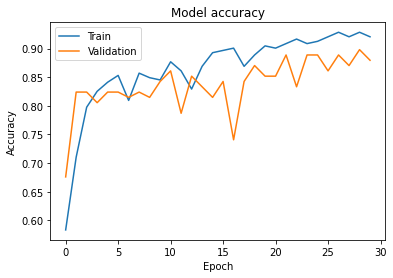

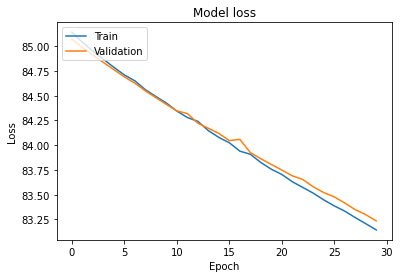

In [103]:
import matplotlib.pyplot as plt

# 정확도 시각화
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# 손실값 시각화
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

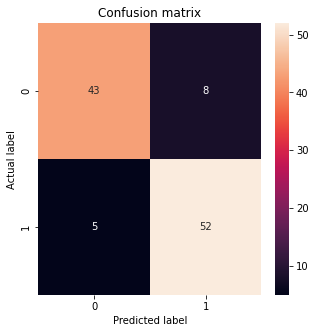

In [104]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# confusion matrix 생성
cm = confusion_matrix(y_val, pred_class)

# confusion matrix 출력
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

- 아키텍처를 간소화시키고 learning_rate를 조절하니 값이 다양하게 나오고 정확도가 0.3 -> 0.6까지 올랐다  
- 유명인 100장 시도  
1차 시도: 0.63(77)  
2차 시도: 40(99)  
3차 시도: 0.37(33)  
4차 시도: 0.53(316)  
- 데이터를 바꾸니까 0.6 -> 0.9까지 올랐다  
- 알반인 200장 시도  
1차 시도: 0.92(316)  
2차 시도: 0.65(99)  
3차 시도: 0.82(1004)  
4차 시도: 0.75(42)  
- 다시 VGG16의 본래 아키텍처로 다시 시도 (learning rate는 그대로 1e-6)  
1차 시도: 0.52(42)  
2차 시도: 0.35(55)  
3차 시도: 0.47(1004)  
4차 시도: 0.45(316)  
 -> 다시 기울기를 잃는 모습을 확인할 수 있다 그러므로 깊이를 축소시키는게 답이었다  
 -> 원핫인코딩으로 바꾸고 이진분류 손실함수로 바꾸고 softmax를 sigmoid로 바꾸었지만 기존의 아키텍처로는 예측값이 계속 0 혹은 1로만 나오는 것을 알 수 있다.  
 
- 음?? 데이터 수만 늘렸을 뿐인데 갑자기 0과 1이 골고루 출력되는 현상을 발견하였다.

## (7) TEST

In [33]:
class_name = ["웜톤", "쿨톤"]

In [53]:
# test 불러오기 (낱개 버전)
test_path = "/aiffel/aiffel/project/first-repository/data/four_seasons/TEST/박은빈.jpg"
x_test = Image.open(test_path)
x_test = np.array(x_test)
print(x_test.shape)

# 배열의 크기 변환
x_test = x_test.reshape((1, x_test.shape[0], x_test.shape[1], 3))
print("변환된 배열 크기:", x_test.shape)

# 전처리(resize, 정규화)
x_test = preprocess_image(x_test)
print(x_test.shape)

# 만약 앱구현과 연결된다면 저장된 모델을 다시 돌릴 필요없이 저장된 최적의 모델을 사용하도록 수정해야함
# test
pred = model.predict(x_test)
pred_class = np.argmax(pred, axis=1)
print("당신은", class_name[int(pred_class)], "입니다~!")
print("웜톤일 확률: ", np.round(pred[:, 0], 3))
print("쿨톤일 확률: ", np.round(pred[:, 1], 3))

(275, 183, 3)
변환된 배열 크기: (1, 275, 183, 3)
(1, 224, 224, 3)
당신은 쿨톤 입니다~!
웜톤일 확률:  [0.005]
쿨톤일 확률:  [0.995]


In [159]:
# 박은빈 쿨톤, 강혜원 웜톤 맞춤!!